In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import string
import re
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

%matplotlib inline

In [2]:
#Reading the data and extracting relevant information for future use

df1 = pd.read_json('Cell_Phones_and_Accessories_5.json', lines=True)
pd.set_option('display.max_colwidth', -1)
df = df1[df1.columns[4:6]]

#Converting ratings to sentiments, rating below 3 is negative, above is positive. (NOTE: There is no neutral sentiment here)
df['sentiment'] = [1 if x > 3 else 0 for x in df.overall]

df.head(2)

C:\Users\visha\Anaconda3\envs\Leena\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,reviewText,overall,sentiment
0,They look good and stick good! I just don't like the rounded shape because I was always bumping it and Siri kept popping up and it was irritating. I just won't buy a product like this again,4,1
1,These stickers work like the review says they do. They stick on great and they stay on the phone. They are super stylish and I can share them with my sister. :),5,1


In [184]:
#Checking for null-entries

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194439 entries, 0 to 194438
Data columns (total 3 columns):
reviewText    194439 non-null object
overall       194439 non-null int64
sentiment     194439 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.5+ MB


In [3]:
#No. of unique products in the dataset

df1.asin.unique().shape

(10429,)

5    108664
4    39993 
3    21439 
1    13279 
2    11064 
Name: overall, dtype: int64

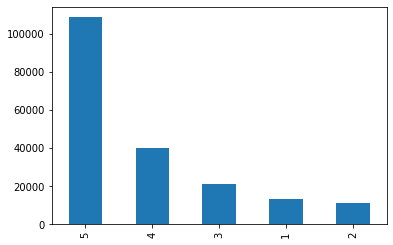

In [4]:
#Getting an overview of distribution of classes

data_reviews = df.reviewText
data_ratings = df.overall
data_sentiments = df.sentiment

reviews = np.array(data_reviews)
ratings = np.array(data_ratings)
sentiments = np.array(data_sentiments)

data_ratings.value_counts().plot(kind='bar')
data_ratings.value_counts()

#dataset is imbalanced, so we will use stratified sampling to generate train-test split (we can try )

In [5]:
#Due to limmitations of my machine, only using a part of the dataset 

data_size = df1['overall'].value_counts().sum()

In [6]:
#Custom funtions for text processing

def remove_stopwords(text):
    
        stopwords_list = stopwords.words('english')
        
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = text.split()
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        
        return " ".join(clean_words)
    
    
def stem(text):
    
        porter = PorterStemmer()
        words = text.split() 
        stemmed_words = [porter.stem(word) for word in words]
        
        return " ".join(stemmed_words)
    
    
def lemmatize(tokens):
    
    lemmatizer = WordNetLemmatizer()
    lemma = [lemmatizer.lemmatize(token) for token in tokens]
    
    return lemma


In [55]:
#Pre-processing and tokenizing 

def create_tokens(reviews):
    
    tokenized_reviews = []
      
    for review in reviews:
        
        review = review.lower()
        review = remove_stopwords(review)
        review = stem(review)
        review = re.sub(r"n't", " not", review)
        review = "".join(char for char in review if char not in string.punctuation)
        review = re.sub(r'[^ a-z A-Z 0-9]', " ", review)
        tokens = word_tokenize(review)
#        tokens = lemmatize(w)
        tokenized_reviews.append([word.lower() for word in tokens])    

    return tokenized_reviews


    
tokenized_reviews = np.array(create_tokens(reviews[:data_size]))


In [182]:
#Get bigrams (these bigrams are used later for visualization of frequent words)

def convertTuple(tup): 
    str =  ' '.join(tup) 
    return str

import nltk
from nltk import word_tokenize 
from nltk.util import ngrams

tokenized_bigrams = []

for review in tokenized_reviews[:data_size]:
    
    sent_bigrams = []
    bigrams = list(ngrams(review, 2))
    
    for bigram in bigrams:
        
        bigram = convertTuple(bigram)
        sent_bigrams.append(bigram)
        
    tokenized_bigrams.append(sent_bigrams)
    
tokenized_bigrams = np.array(tokenized_bigrams)

In [8]:
#Preparing data for training (we will be using bag of words model)

use_reviews = tokenized_reviews
use_ratings = ratings[:data_size].reshape(data_size, )
use_sentiments = sentiments[:data_size].reshape(data_size, )

use_reviews.shape, use_ratings.shape

((194439,), (194439,))

In [9]:
#Preparing the test & training set, using Stratified sampling as classes are imbalanced (could use duplication of reviews from negative class to balance)

from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
sss.get_n_splits(use_reviews, use_ratings)

for train_index, test_index in sss.split(use_reviews, use_ratings):
    train_X, test_X = use_reviews[train_index], use_reviews[test_index]
    train_Y, test_Y = use_sentiments[train_index], use_sentiments[test_index]
    
print("Shape of train_X = %s and train_Y = %s" % (train_X.shape, train_Y.shape))
print("Shape of test_X = %s and test_Y = %s" % (test_X.shape, test_Y.shape))

Shape of train_X = (155551,) and train_Y = (155551,)
Shape of test_X = (38888,) and test_Y = (38888,)


In [10]:
#For future use (just in case)

train1_X = train_X.copy()
train1_Y = train_Y.copy()
test1_X = test_X.copy()
test1_Y = test_Y.copy()

In [11]:
#Finding all words and their frequencies

from nltk import FreqDist

def bow(text):
    
    all_words = []
    
    for sentence in text:
        
        for word in sentence:
            
            all_words.append(word.lower())
            
    all_words = FreqDist(all_words)

    return all_words

Total words =  181218


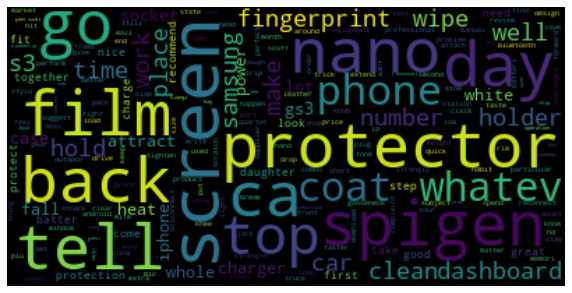

In [12]:
#Using worldcloud to visualize common words

from wordcloud import WordCloud

all_words = bow(train_X)
ax = plt.figure(figsize=(10,10))
# Generate a word cloud image
wordcloud = WordCloud(background_color='black',max_font_size=50).generate(' '.join(all_words.keys()))

# Display the generated image:

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
print("Total words = ",len(all_words))

In [13]:
positive_reviews = train_X[train_Y == 1]
negative_reviews = train_X[train_Y == 0]

In [14]:
test_positive_reviews = test_X[test_Y == 1]
test_negative_reviews = test_X[test_Y == 0]

test_positive_reviews.shape, test_negative_reviews.shape

((29731,), (9157,))

In [15]:
positive_reviews.shape, negative_reviews.shape

((118926,), (36625,))

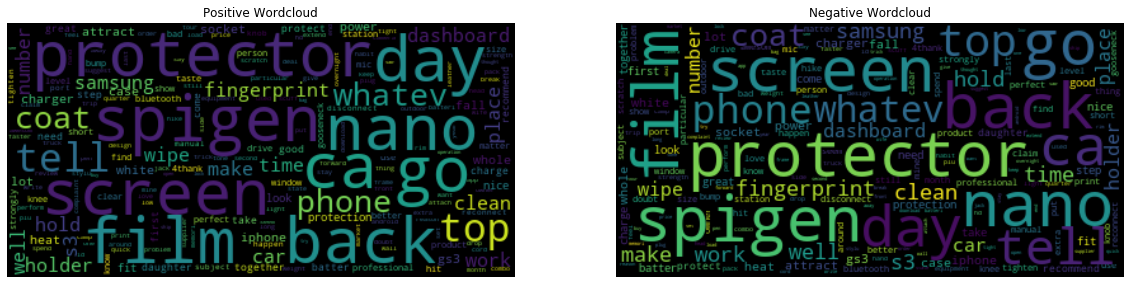

In [16]:
positive_words = bow(positive_reviews)
negative_words = bow(negative_reviews)

f = plt.figure(figsize=(20,20))


# Generate a word cloud image
positive_wordcloud = WordCloud(background_color='black',max_font_size=50).generate(' '.join(all_words.keys()))
negative_wordcloud = WordCloud(background_color='black',max_font_size=50).generate(' '.join(all_words.keys()))

# Display the generated image:

f.add_subplot(1,2,1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title("Positive Wordcloud")
plt.axis("off")

f.add_subplot(1,2, 2)
plt.title("Negative Wordcloud")
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis("off")

plt.show(block=True)




In [17]:
#Most frequent words in the positive class
positive_words

FreqDist({'phone': 114917, 'case': 96904, 'not': 80259, 'use': 72210, 'one': 56206, 'charg': 53155, 'like': 49493, 'great': 47388, 'work': 43750, 'screen': 37631, ...})

In [18]:
#Most frequent words in the negative class
negative_words

FreqDist({'not': 40119, 'phone': 34454, 'case': 31342, 'use': 19618, 'one': 16219, 'like': 14832, 'get': 13949, 'work': 13829, 'would': 12279, 'screen': 11733, ...})

In [19]:
#Using CountVectorizer to train bag of words model

def do_nothing(tokens):
    
    #Does nothing, used so that we can pass our custom tokens rather than using the stock tokenizer
    return tokens

# Vectorize train_X
vectorizer = CountVectorizer(min_df=5, tokenizer=do_nothing, preprocessor=do_nothing).fit(train_X)
train_X = vectorizer.transform(train_X)
test_X = vectorizer.transform(test_X)

print("X_train:\n{}".format(repr(train_X)))

X_train:
<155551x23526 sparse matrix of type '<class 'numpy.int64'>'
	with 5702363 stored elements in Compressed Sparse Row format>


In [20]:
#Using grid search to find optimum features for random forest classifier (here only used single values as computationally expensive on my machine)

from sklearn.model_selection import GridSearchCV
param_grid = [
{'n_estimators': [30], 'max_features': [90]}]

from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=20)
grid_search = GridSearchCV(clf, param_grid=param_grid, cv=5, iid=False)
grid_search.fit(train_X, train_Y)
grid_search.score(train_X, train_Y), grid_search.best_params_

(0.9994149828673554, {'max_features': 90, 'n_estimators': 30})

In [21]:
grid_search_score = grid_search.score(test_X, test_Y)
print('GridSearchCV score = {}%'.format(grid_search_score*100))

GridSearchCV score = 81.87358568195845%


In [22]:
#Training a logistic Regression model on the dataset

logistic = LogisticRegression(C=0.1).fit(train_X, train_Y)

train_pred = logistic.predict(train_X)
test_pred = logistic.predict(test_X)

train_score = accuracy_score(train_Y, train_pred)
test_score = accuracy_score(test_Y, test_pred)

print("Training Accuracy = {}%".format(train_score*100))
print("Test Accuracy = {}%".format(test_score*100))

C:\Users\visha\Anaconda3\envs\Leena\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Training Accuracy = 87.0634068569151%
Test Accuracy = 85.01851470890763%


In [23]:
#Calculating F1 score

from sklearn.metrics import classification_report

log_cfm = confusion_matrix(test_Y, test_pred)
print("Confusion matrix:")
print(log_cfm, end='\n\n')

print(np.array([['TN', 'FP'],[ 'FN' , 'TP']]))
print('\n\n')

print(classification_report(test_Y, test_pred, labels=[0,1], target_names=['negative', 'positive']))

Confusion matrix:
[[ 4980  4177]
 [ 1649 28082]]

[['TN' 'FP']
 ['FN' 'TP']]



              precision    recall  f1-score   support

    negative       0.75      0.54      0.63      9157
    positive       0.87      0.94      0.91     29731

    accuracy                           0.85     38888
   macro avg       0.81      0.74      0.77     38888
weighted avg       0.84      0.85      0.84     38888



In [24]:
#the model errors are mainly due to misclassification of the negative class
#possible reasons include less number of training examples

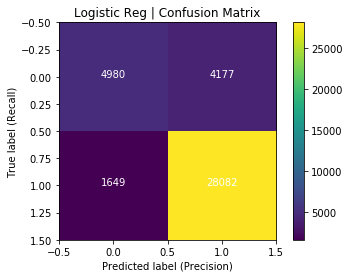

In [25]:
#Fancy confusion matrix

import itertools
plt.imshow(log_cfm, interpolation='nearest')

for i, j in itertools.product(range(log_cfm.shape[0]), range(log_cfm.shape[1])):
    plt.text(j, i, log_cfm[i, j],
             horizontalalignment="center",
             color="white")

plt.ylabel('True label (Recall)')
plt.xlabel('Predicted label (Precision)')
plt.title('Logistic Reg | Confusion Matrix')
plt.colorbar();

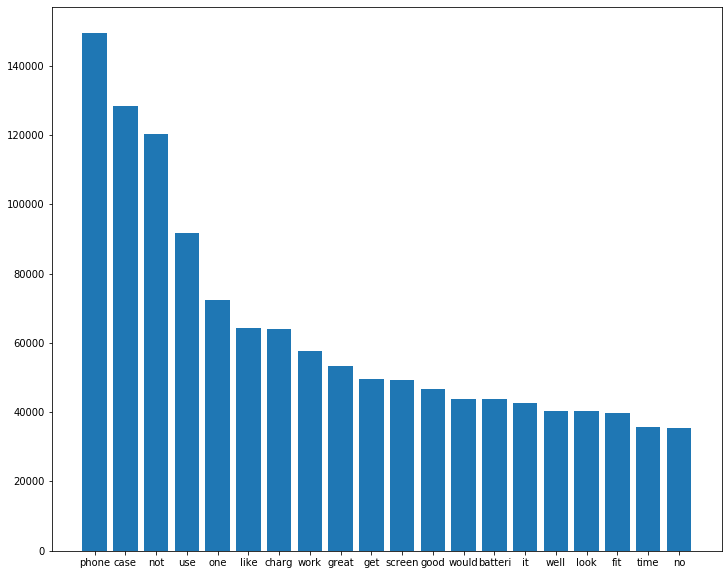

,word,freq
0,phone,149371
1,case,128246
2,not,120378
3,use,91828
4,one,72425
5,like,64325
6,charg,63936
7,work,57579
8,great,53403
9,get,49425


In [26]:
#most frequent words in the training data

import collections

cv = CountVectorizer(min_df=5, tokenizer=do_nothing, preprocessor=None, lowercase=False).fit(train1_X)
bag = cv.transform(train1_X)

word_freq = dict(zip(cv.get_feature_names(), np.asarray(bag.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])

fig, ax = plt.subplots(figsize=(12, 10))
plt.bar(x='word', height='freq', data=word_counter_df)
plt.show();

word_counter_df

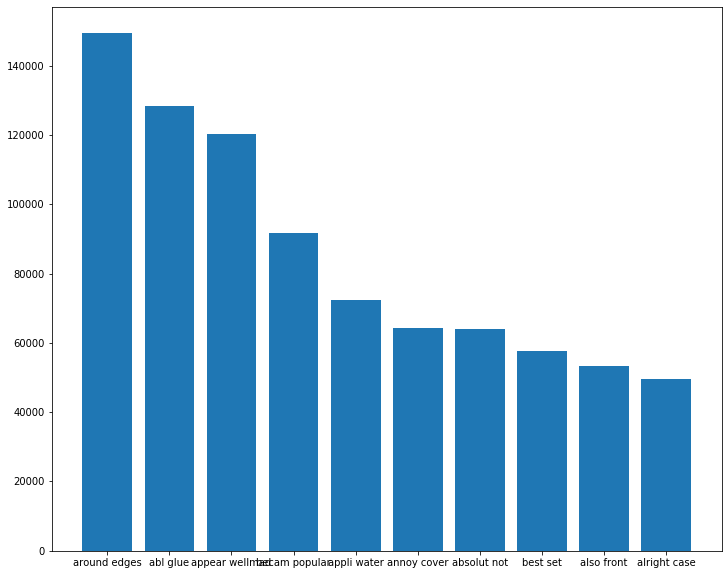

,word,freq
0,around edges,149371
1,abl glue,128246
2,appear wellmad,120378
3,becam popular,91828
4,appli water,72425
5,annoy cover,64325
6,absolut not,63936
7,best set,57579
8,also front,53403
9,alright case,49425


In [183]:
#Most common bigram features in the dataset

import collections


cv_1 = CountVectorizer(min_df=5, tokenizer=do_nothing, preprocessor=None, lowercase=False).fit(tokenized_bigrams)
bag_1 = cv_1.transform(tokenized_bigrams)

word_freq_1 = dict(zip(cv_1.get_feature_names(), np.asarray(bag.sum(axis=0)).ravel()))
word_counter_1 = collections.Counter(word_freq_1)
word_counter_df_1 = pd.DataFrame(word_counter_1.most_common(10), columns = ['word', 'freq'])

fig, ax = plt.subplots(figsize=(12, 10))
plt.bar(x='word', height='freq', data=word_counter_df_1)
plt.show();

word_counter_df_1

In [27]:
#--------------------------------------TOPIC EXTRACTION--------------------------------------------------------

In [29]:
'''
Left this in favour of implementation of LDA in gensim 


from sklearn.decomposition import LatentDirichletAllocation
# Vectorize train_X

def do_nothing(tokens):
    return tokens

cv = CountVectorizer(min_df=5, tokenizer=do_nothing, preprocessor=do_nothing)
tf = cv.fit_transform(tokenized_reviews)

feature_names = cv.get_feature_names()
print("Number of total features: {}".format(len(feature_names)))

lda = LatentDirichletAllocation(n_components=9, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=42)

num_top_words = 10

def retrieve_top_words(model, feature_names, num_top_words):
    for idx, topic in enumerate(model.components_):
        print("Topic #{}:".format(idx), end='\n')
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-num_top_words - 1:-1]]), end='\n\n')
    print()
    
    
lda_tf = lda.fit(tf)
lda_transformed = lda.transform(tf)

import collections
collections.Counter(sorted([np.argmax(i) for i in lda_transformed]))

retrieve_top_words(lda_tf, feature_names, num_top_words)

X_train:
<194439x27156 sparse matrix of type '<class 'numpy.int64'>'
	with 7141606 stored elements in Compressed Sparse Row format>


In [41]:
#----------------------LDA using gensim---------------------------------------

In [ ]:
#Finding the different categories of reviews present in the dataset and the most relevant words for those topics

In [42]:
#np.random.seed(42)
#np.random.shuffle(tokenized_reviews)


In [56]:
from gensim import models, corpora

In [186]:
#Creating dictionary 

dictionary_LDA = corpora.Dictionary(tokenized_reviews)
dictionary_LDA.filter_extremes(no_below = 3)


import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

#number of topics, alpha, eta are hyperparameters and has to be set by trial and error of examining different values and getting
#an idea of how many categories exist in the data (or having that knowledge by some other means)

corpus = [dictionary_LDA.doc2bow(tokens) for tokens in tokenized_reviews]
num_topics = 9

lda_model = models.LdaModel(corpus, num_topics=num_topics, \
                                  id2word=dictionary_LDA, \
                                  passes=3, alpha=[0.01]*num_topics, \
                                  eta=[0.01]*len(dictionary_LDA.keys()))



C:\Users\visha\Anaconda3\envs\Leena\lib\site-packages\gensim\models\ldamodel.py:775: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


In [187]:
#Showing the different topics found and the most relevant words

for topic in lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=10):
    print(topic)
    print('\n')

(0, '0.043*"phone" + 0.025*"use" + 0.018*"hold" + 0.018*"mount" + 0.018*"work" + 0.016*"not" + 0.014*"place" + 0.012*"well" + 0.010*"fit" + 0.009*"stand"')


(1, '0.079*"batteri" + 0.031*"phone" + 0.030*"charg" + 0.025*"galaxi" + 0.021*"samsung" + 0.018*"use" + 0.014*"note" + 0.013*"day" + 0.013*"battery" + 0.013*"hour"')


(2, '0.108*"case" + 0.044*"phone" + 0.022*"protect" + 0.020*"fit" + 0.019*"like" + 0.018*"look" + 0.017*"not" + 0.014*"great" + 0.013*"love" + 0.012*"nice"')


(3, '0.050*"phone" + 0.017*"use" + 0.012*"not" + 0.012*"app" + 0.010*"bank" + 0.009*"card" + 0.009*"android" + 0.008*"watch" + 0.007*"get" + 0.007*"camera"')


(4, '0.030*"one" + 0.030*"not" + 0.020*"work" + 0.017*"it" + 0.016*"product" + 0.014*"get" + 0.013*"would" + 0.013*"great" + 0.013*"like" + 0.011*"buy"')


(5, '0.032*"speaker" + 0.030*"sound" + 0.024*"bluetooth" + 0.016*"use" + 0.014*"not" + 0.013*"good" + 0.013*"music" + 0.011*"pair" + 0.011*"ear" + 0.010*"headset"')


(6, '0.094*"screen" + 0.060*"pr

In [188]:
#Sorting reviews by topics identified using LDA to get a better idea of the content in the topics
#Here the variable 'confidence' has been set to 0.7 meaning that the document is 70% about that topic, this is a hyperparameter I have usedd to extract
#examples of a certain topic

topics = [[] for i in range(9)]

#Using first 50000 reviews to get an idea of the topic
for index in range(50000):
    
    for category,confidence in lda_model[corpus[index]]:
        
        if confidence > 0.7:
            
            topics[category].append(reviews[index])
            continue

In [189]:
#Number of reviews foundd on each topic fullfilling the 'confidence' criteria

for topic in topics:
    print(len(topic), end=' ')

400 785 4291 330 4000 1343 1179 1089 85 

In [210]:
#An example of contents in a found topic, it appears this topic is 'Phone Cases'
topics[2][20:30]

['I prefer this style case to the otterbox and case mate as I feel it provides ample protection without turning the phone into a brick. Lightweight and sleek.',
 'I like the case so far fits ok my Samsung Galaxy S2 I like that is very shiny and soft to the touch. My only concern is one of the corners is not totally covered so it wont protect it from scratches or a hit there that is why I am just giving it 4 stars. Well for the price i think it is ok.',
 'I made a good choice whenI thought of buying this, its very safe, & not to bulky! Overall very satisfied customer.',
 'this case is better than i thought i love the feel and design and it is well made and doen not collect dust.',
 'Bought as gift for my relative and he loves it.....Great job...Would highly recommend this product to all customers.Thank you',
 'good',
 "It's shiny which is pretty but that makes it a fingerprint magnet. Its just okay. I buy a lot of cases for my phones because I like to switch them out a lot. This one is 

In [50]:
#NOTE: These may differe on subsequent runs of the program as randomness was not dealt with during creation
#0. Mounting Stand
#1. Battery
#2. Phone Case
#3. Phone
#4. Opinion
#5. Bluetooth Headset
#6. Screen Protector
#7. Charger/ Cable/ Charging accessories
#8. This topic had the fewest examples, so either its material is common with other topics and hence rarely achieves 0.7 confidence or is a rare topic


In [209]:
#Using pyLDAvis to better visualize the results of LDA

import pyLDAvis
import pyLDAvis.gensim

vis = pyLDAvis.gensim.prepare(topic_model=lda_model, corpus=corpus, dictionary=dictionary_LDA)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

C:\Users\visha\Anaconda3\envs\Leena\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [86]:
# topic-1 = Cases
# topic-2 = Opinions
# topic-3 = Unknown
# topic-4 = Chargers
# topic-5 = BT Headsets
# topic-6 = Phones
# topic-7 = Batteries
# topic-8 = Screen Protectors
# topic-9 = Mounting Devices

In [316]:
#--------------Bonus Question-------------------------

In [319]:
'''

Task - To find find features of a product and then rate overall sentiment about those features. 

Approach: There are only two products in this dataset which can have multiple features, Bluetooth Headsets (possible features - sound, 
battery, size/feel), and Cellphones.


Step-1 : Find some reviews of phones

Using topic extraction, we have extracted cellphone reviews (topic-3). We can use these
to feed to another topic extraction algorithm to get the features, then find the words in the reviews related to those topics
and classify the user sentiment. We would need to segregate the reviews (found using LDA) using the product ID to find reviews 
that belong to the same cellphone and average the sentiment of users.

The other approach would be to just find the cellphone reviews directly from the dataset using occurencce of terms such as (camera, battery, display) and
then use LDA to model those features

'''

'\n\nTask - To find find features of a product and then rate overall sentiment about those features. \n\nApproach: There are only two products in this dataset which can have multiple features, Bluetooth Headsets (possible features - sound, \nbattery, size/feel), and Cellphones.\n\n\nStep-1 : Find some reviews of phones\n\nUsing topic extraction, we have extracted cellphone reviews (topic-3). We can use these\nto feed to another topic extraction algorithm to get the features, then find the words in the reviews related to those topics\nand classify the user sentiment. We would need to segregate the reviews (found using LDA) using the product ID to find reviews \nthat belong to the same cellphone and average the sentiment of users.\n\nThe other approach would be to just find the cellphone reviews directly from the dataset using occurencce of terms such as (camera, battery, display) and\nthen use LDA to model those features\n\n'

In [320]:
'''

The first technique of finding features of phones by feeding it reviews which we earlier clustered as 'Phones' (topic 3), but that had poor results 
as it focused on brand names as topics but mostly because there are very few phones reviews that discuss all of [camera, screen, display]. And if we look
for these features individually, then we will get many non-phone reviews

So, I tried the second approach of gathering phone reviews by searching for reviews that contained all of the words [camera, screen/display, battery]
I used these reviews to create my dataset (of size 847 (of which not all were necessarily phone reviews)) to feed to LDA but it failed to recognise these 
features and focused mainly on brand names. This  problem arose because these were reviews of different phones so finding the names of the phones was 
correct in terms of topic identification but not to our requirement.

So now I tried to extract reviews of just one particular product by going through the productID of the different reviews found above but the 
THING TO NOTE here is that it is not neccessary that all the reviews of a particular phone may mention those features. Also, there were very less reviews
of any particular phone. 


'''

"\n\nThe first technique of finding features of phones by feeding it reviews which we earlier clustered as 'Phones' (topic 3), but that had poor results \nas it focused on brand names as topics but mostly because there are very few phones reviews that discuss all of [camera, screen, display]. And if we look\nfor these features individually, then we will get many non-phone reviews\n\nSo, I tried the second approach of gathering phone reviews by searching for reviews that contained all of the words [camera, screen/display, battery]\nI used these reviews to create my dataset (of size 847 (of which not all were necessarily phone reviews)) to feed to LDA but it failed to recognise these \nfeatures and focused mainly on brand names. This  problem arose because these were reviews of different phones so finding the names of the phones was \ncorrect in terms of topic identification but not to our requirement.\n\nSo now I tried to extract reviews of just one particular product by going through t

In [321]:
#Finding all reviews that mention all of these keywords - screen, battery, camera (since any less number of keywords and we would have our hands full
#of phone cases or screen protectors)

features = ['screen', 'battery', 'camera']

productID = []
phone_reviews = []

for index,review in enumerate(reviews[:df1['overall'].value_counts().sum()]):
        
    if all(feature in review for feature in features) and int(df1.reviewTime[i][-4:]) > 2010:
#        print(df1.asin[index])
#        print(df1.reviewText[index])

        productID.append(df1.asin[index])
        phone_reviews.append(review)
        
productID = np.array(productID)
len(phone_reviews)

847

In [334]:
#430 unique products that mention our keyword
unique = np.unique(productID, return_index=True)[0]
unique.shape

(430,)

In [323]:
#To find number of available reviews of a particular product

review_counts = df1['asin'].value_counts().to_dict()

def available_reviews(asin):
    return review_counts[asin]


In [324]:
#For analysis of number of reviews

counts = []
for asin in unique:
    counts.append(available_reviews(asin))
    
counts = np.array(counts)

(array([393.,  24.,   6.,   3.,   1.,   1.,   1.,   0.,   0.,   1.]),
 array([  5. ,  70.2, 135.4, 200.6, 265.8, 331. , 396.2, 461.4, 526.6,
        591.8, 657. ]),
 <a list of 10 Patch objects>)

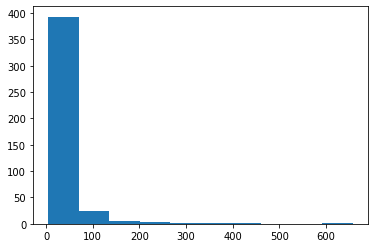

In [325]:
plt.hist(counts)

In [326]:
#most products have <70 reviews

In [327]:
#Since the product returned by argmax was actually a phone case (one of the reviews for that product must have passed the [camera, screen, battery] test)
#I did some frequency count analysis to see where there was a sudden drop in number of reviews available for the product as phones have less reviews

#after some analysis of productIDs and review counts, I found a phone with 38 reviews going throug some productIDs to find a relevant one

In [328]:
#The product that was both a phone and had at least 10 reviews (still not all reviews mentioned camera/battery etc. :/ )

df1.reviewText[df1.asin == 'B001BZH2QI'][:2]

6288    This phone is awesome. came pretty fast with super saver shipping. the phone itself is great. its super sleek and sexy. slimmer than any other smartphone out there that ive seen. all my friends that have blackberry phones are mezmerized by the nokia e71 when i pull it out and ask to see it. i'm always receiving compliments on it. it is easy to use and battery life is good. its not cheaply made. the frame is solid and durable. the battery cover is securely attached and will not come off with the battery if you drop it. (has 2 latches on either side u have to press to release) so thats kinda cool too. (tho u shouldn't be dropping phones lol) my only gripe with this phone is that it does not have threaded messaging. However there is a program you can download called "conversations" that will thread your messages, however its still not up to par on that regard. but definitely not a deal breaker. one other area of concern is the camera. in low light situations the photo comes out gr

In [329]:
phone_reviews = df1.reviewText[df1.asin == 'B001BZH2QI']

In [340]:
def convertTuple(tup): 
    str =  ' '.join(tup) 
    return str

import nltk
from nltk import word_tokenize 
from nltk.util import ngrams

phones_tokenized = np.array(create_tokens(phone_reviews))

phones_ngrams = []

for review in phones_tokenized:
    
    sent_ngrams = []
    n_grams = list(ngrams(review, 1))
    
    for ngram in n_grams:
        
        ngram = convertTuple(ngram)
        sent_ngrams.append(ngram)
        
    phones_ngrams.append(sent_ngrams)
    
phones_ngrams = np.array(phones_ngrams)

In [341]:
dictionary_LDA = corpora.Dictionary(phones_ngrams)
dictionary_LDA.filter_extremes(no_below = 1)


import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

#number of topics is a hyperparameter and has to be set by trial and error of examining different values and getting
#an idea of how many categories exist in the data (or having that knowledge by some other means)

corpus = [dictionary_LDA.doc2bow(tokens) for tokens in phones_ngrams]
num_topics = 4

lda_model = models.LdaModel(corpus, num_topics=num_topics, \
                                  id2word=dictionary_LDA, \
                                  passes=3, alpha=0.1, \
                                  eta=0.01)



C:\Users\visha\Anaconda3\envs\Leena\lib\site-packages\gensim\models\ldamodel.py:775: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


In [342]:
for topic in lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=7):
    print(topic)
    print()

(0, '0.014*"nice" + 0.012*"e71" + 0.010*"camera" + 0.010*"realli" + 0.009*"app" + 0.008*"qualiti" + 0.007*"get"')

(1, '0.009*"work" + 0.009*"call" + 0.008*"like" + 0.008*"web" + 0.007*"it" + 0.007*"tmobil" + 0.006*"im"')

(2, '0.013*"e71" + 0.009*"e71x" + 0.009*"work" + 0.008*"like" + 0.008*"get" + 0.008*"even" + 0.007*"better"')

(3, '0.013*"no" + 0.013*"work" + 0.013*"good" + 0.012*"solid" + 0.010*"e71x" + 0.010*"well" + 0.009*"get"')



In [343]:
#Looks like we found something related to camera but not much to work with otherwise

In [344]:
#Wasn't going to produce good results anyways as the dataset is not up to mark. Very few datapoints and even those don't all mention relevant topics

In [ ]:
#References - http://cs229.stanford.edu/proj2018/report/122.pdf